In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score
from tqdm import tqdm
import os

# Use CUDA if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

# Define the dataset class
class HateData(Dataset):
    def __init__(self, data_path, split='train', lang='bengali', layer=1, model_name='roberta-base'):
        self.layer = layer
        self.model_name = model_name
        self.split = split
        self.lang = lang
        self.data_path = data_path
        self.embedding_file = f"{data_path}{lang}_{split}_layer_{layer}_{model_name.replace('/', '_')}_embeddings.npy"
        self.df = pd.read_csv(data_path + lang + "_" + split + ".tsv", sep='\t')

        if os.path.exists(self.embedding_file):
            # Load precomputed embeddings if they exist
            self.embeddings = np.load(self.embedding_file)
            print(f"Loaded embeddings from {self.embedding_file}")
        else:
            # Otherwise generate and save them
            self.embeddings = self.generate_embeddings()
            np.save(self.embedding_file, self.embeddings)
            print(f"Saved embeddings to {self.embedding_file}")

    def generate_embeddings(self):
        tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        model = AutoModel.from_pretrained(self.model_name).to(device)
        model.eval()

        embeddings = []
        for text in tqdm(self.df['post'], desc="Generating embeddings"):
            inputs = tokenizer(text, return_tensors="pt", padding='max_length', truncation=True, max_length=128).to(device)
            with torch.no_grad():
                outputs = model(**inputs, output_hidden_states=True)
            embeddings.append(outputs.hidden_states[self.layer].mean(dim=1).squeeze().cpu().numpy())

        return np.array(embeddings)

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, index):
        emb = self.embeddings[index]
        labels = self.df.iloc[index][1]
        
        emb = torch.tensor(emb, dtype=torch.float).view(768)
        labels = torch.tensor(labels, dtype=torch.long)

        return emb, labels

# Define the classifier class
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        H1, H2, num_class = 768, 128, 2
        self.clf = nn.Sequential(nn.Linear(H1, H2), nn.ReLU(), nn.Linear(H2, num_class))

    def forward(self, emb):  
        logits = self.clf(emb)
        return logits

# Training and evaluation functions
def train(emb, label, model, model_opt, scdl):
    model_opt.zero_grad()
    loss_fn = nn.CrossEntropyLoss()
    batch_size = emb.shape[0]

    if use_cuda:
        emb = emb.to(device)
        label = label.to(device)

    label = label.flatten()
    logits = model(emb)
    loss = loss_fn(logits, label)

    loss.backward()
    model_opt.step()
    scdl.step()
    return float(loss.item())

def evaluate(emb, label, model):
    with torch.no_grad():
        if use_cuda:
            emb = emb.to(device)
            label = label.to(device)

        label = label.flatten()
        logits = model(emb)
        preds = torch.argmax(logits, dim=1).flatten()
        return preds.cpu().numpy()

# Training iterations function
def trainIters(layer, model, epochs, train_loader, test_loader, learning_rate=1e-3):
    model_opt = torch.optim.AdamW(model.parameters(), lr=learning_rate, eps=1e-8)
    num_train_steps = (len(train_loader) * epochs)
    scdl = torch.optim.lr_scheduler.StepLR(model_opt, step_size=100, gamma=0.9)

    gt_labels = np.array(pd.read_csv("data/latenthatred/latent_test.tsv", sep='\t')['class'])
    best_f1 = 0.0

    for epoch in range(epochs):
        model.train()  
        for entry in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            train(entry[0], entry[1], model, model_opt, scdl)
        
        model.eval()
        test_preds = []
        for entry in tqdm(test_loader, desc="Evaluating", leave=False):
            preds = evaluate(entry[0], entry[1], model)
            test_preds.extend(preds)

        val_f1 = f1_score(gt_labels, test_preds, average='macro')
        best_f1 = max(best_f1, val_f1)

    return best_f1


Probing model: roberta-base

Training for layer 2
Loaded embeddings from data/latenthatred/latent_train_layer_2_roberta-base_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_2_roberta-base_embeddings.npy



Training for layer 4
Loaded embeddings from data/latenthatred/latent_train_layer_4_roberta-base_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_4_roberta-base_embeddings.npy



Training for layer 6
Loaded embeddings from data/latenthatred/latent_train_layer_6_roberta-base_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_6_roberta-base_embeddings.npy



Training for layer 8
Loaded embeddings from data/latenthatred/latent_train_layer_8_roberta-base_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_8_roberta-base_embeddings.npy



Training for layer 10
Loaded embeddings from data/latenthatred/latent_train_layer_10_roberta-base_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_10_roberta-base_embeddings.npy



Training for layer 12
Loaded embeddings from data/latenthatred/latent_train_layer_12_roberta-base_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_12_roberta-base_embeddings.npy



Probing model: cardiffnlp/twitter-roberta-base

Training for layer 2
Loaded embeddings from data/latenthatred/latent_train_layer_2_cardiffnlp_twitter-roberta-base_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_2_cardiffnlp_twitter-roberta-base_embeddings.npy



Training for layer 4
Loaded embeddings from data/latenthatred/latent_train_layer_4_cardiffnlp_twitter-roberta-base_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_4_cardiffnlp_twitter-roberta-base_embeddings.npy



Training for layer 6
Loaded embeddings from data/latenthatred/latent_train_layer_6_cardiffnlp_twitter-roberta-base_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_6_cardiffnlp_twitter-roberta-base_embeddings.npy



Training for layer 8


Generating embeddings: 100%|██████████| 14273/14273 [01:59<00:00, 119.02it/s]


Saved embeddings to data/latenthatred/latent_train_layer_8_cardiffnlp_twitter-roberta-base_embeddings.npy


Generating embeddings: 100%|██████████| 4079/4079 [00:34<00:00, 119.12it/s]


Saved embeddings to data/latenthatred/latent_test_layer_8_cardiffnlp_twitter-roberta-base_embeddings.npy



Training for layer 10


Generating embeddings: 100%|██████████| 14273/14273 [01:59<00:00, 119.04it/s]


Saved embeddings to data/latenthatred/latent_train_layer_10_cardiffnlp_twitter-roberta-base_embeddings.npy


Generating embeddings: 100%|██████████| 4079/4079 [00:34<00:00, 119.09it/s]


Saved embeddings to data/latenthatred/latent_test_layer_10_cardiffnlp_twitter-roberta-base_embeddings.npy



Training for layer 12


Generating embeddings: 100%|██████████| 14273/14273 [01:59<00:00, 119.18it/s]


Saved embeddings to data/latenthatred/latent_train_layer_12_cardiffnlp_twitter-roberta-base_embeddings.npy


Generating embeddings: 100%|██████████| 4079/4079 [00:34<00:00, 119.17it/s]


Saved embeddings to data/latenthatred/latent_test_layer_12_cardiffnlp_twitter-roberta-base_embeddings.npy



Probing model: cardiffnlp/twitter-roberta-base-sentiment

Training for layer 2
Loaded embeddings from data/latenthatred/latent_train_layer_2_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_2_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy



Training for layer 4
Loaded embeddings from data/latenthatred/latent_train_layer_4_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy
Loaded embeddings from data/latenthatred/latent_test_layer_4_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy



Training for layer 6


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 14273/14273 [02:00<00:00, 118.75it/s]


Saved embeddings to data/latenthatred/latent_train_layer_6_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 4079/4079 [00:34<00:00, 118.93it/s]


Saved embeddings to data/latenthatred/latent_test_layer_6_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy



Training for layer 8


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 14273/14273 [01:59<00:00, 119.11it/s]


Saved embeddings to data/latenthatred/latent_train_layer_8_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 4079/4079 [00:34<00:00, 119.16it/s]


Saved embeddings to data/latenthatred/latent_test_layer_8_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy



Training for layer 10


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 14273/14273 [02:00<00:00, 118.88it/s]


Saved embeddings to data/latenthatred/latent_train_layer_10_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 4079/4079 [00:34<00:00, 119.00it/s]


Saved embeddings to data/latenthatred/latent_test_layer_10_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy



Training for layer 12


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 14273/14273 [02:00<00:00, 118.68it/s]


Saved embeddings to data/latenthatred/latent_train_layer_12_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy


Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Generating embeddings: 100%|██████████| 4079/4079 [00:34<00:00, 118.79it/s]


Saved embeddings to data/latenthatred/latent_test_layer_12_cardiffnlp_twitter-roberta-base-sentiment_embeddings.npy


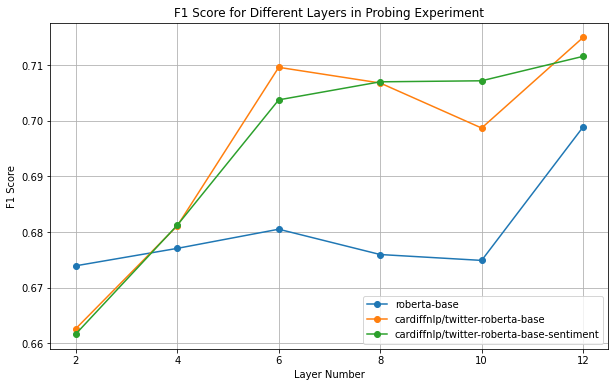

In [2]:
# Main code for probing across different layers and plotting results
models_to_probe = ['roberta-base','cardiffnlp/twitter-roberta-base', 'cardiffnlp/twitter-roberta-base-sentiment']
layer_list = [2, 4, 6, 8, 10, 12]
plt.figure(figsize=(10, 6))
for model_name in models_to_probe:
    print(f"\nProbing model: {model_name}")
    f1_scores = []

    for layer in layer_list:
        print(f"\nTraining for layer {layer}")
        train_data = HateData(data_path="data/latenthatred/", split='train', lang='latent', layer=layer, model_name=model_name)
        val_data = HateData(data_path="data/latenthatred/", split='test', lang='latent', layer=layer, model_name=model_name)

        BS = 64
        dataload = DataLoader(train_data, batch_size=BS, shuffle=True)
        dataload_val = DataLoader(val_data, batch_size=BS, shuffle=False)

        model = Classifier().to(device).float()

        f1_score_layer = trainIters(layer, model, epochs=50, train_loader=dataload, test_loader=dataload_val)
        f1_scores.append(f1_score_layer)

    # Plotting the results for the current model
    plt.plot(layer_list, f1_scores, marker='o', linestyle='-', label=model_name)
plt.xlabel('Layer Number')
plt.ylabel('F1 Score')
plt.title(f'F1 Score for Different Layers in Probing Experiment')
plt.xticks(layer_list)
# plt.yticks(np.arange(0, 1.1, 0.1))  # Make y-axis broader by using a larger step
plt.grid()
plt.legend()
plt.show()
